## Camera Capture
Sử dụng webcam để chụp ảnh

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


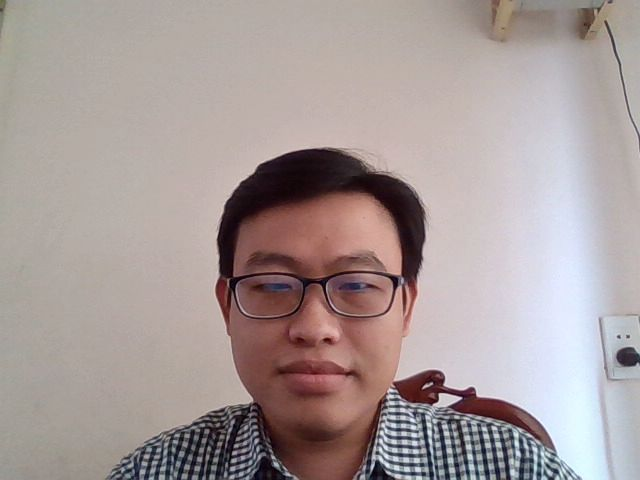

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load caffe model 

In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

print("loading face detector model...")
args_face='/content/drive/My Drive/opencv-age-detection/face_detector/'
prototxtPath = os.path.join(args_face, "deploy.prototxt")
weightsPath = os.path.join(args_face,"res10_300x300_ssd_iter_140000.caffemodel")
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

print("loading age detector model...")
args_age='/content/drive/My Drive/opencv-age-detection/age_detector/'
prototxtPath = os.path.join(args_age, "age_deploy.prototxt")
weightsPath = os.path.join(args_age, "age_net.caffemodel")
ageNet = cv2.dnn.readNet(prototxtPath, weightsPath)


loading face detector model...
loading age detector model...


# Danh sách độ tuổi sẽ được dự đoán

In [ ]:
AGE_BUCKETS = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)",
	"(38-43)", "(48-53)", "(60-100)"]


# Đọc ảnh và đưa ảnh vào trong mô hình

In [ ]:
image = cv2.imread('photo.jpg')
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

# phát hiện khuôn mặt

computing face detections...
[INFO] (25-32): 98.66%


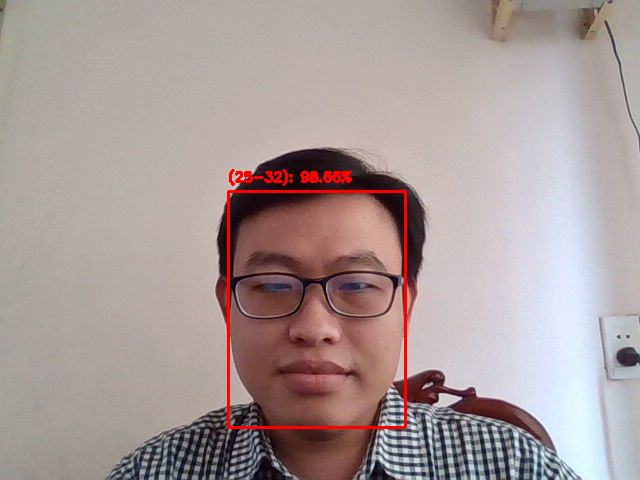

In [ ]:
# pass the blob through the network and obtain the face detections
print("computing face detections...")
faceNet.setInput(blob)
detections = faceNet.forward()
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the
		# object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# extract the ROI of the face and then construct a blob from
		# *only* the face ROI
		face = image[startY:endY, startX:endX]
		faceBlob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),
			(78.4263377603, 87.7689143744, 114.895847746),
			swapRB=False)

		# make predictions on the age and find the age bucket with
		# the largest corresponding probability
		ageNet.setInput(faceBlob)
		preds = ageNet.forward()
		i = preds[0].argmax()
		age = AGE_BUCKETS[i]
		ageConfidence = preds[0][i]

		# display the predicted age to our terminal
		text = "{}: {:.2f}%".format(age, ageConfidence * 100)
		print("[INFO] {}".format(text))

		# draw the bounding box of the face along with the associated
		# predicted age
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# hiển thị hình ảnh đầu ra
cv2_imshow(image)